# Interpolation Analysis
__Author__: Pat McCornack

__Date__: 12/12/24

__Purpose__: Determine the degree of difference between extracting interpolated WRF data for the SCI met. stations and using the nearest pixel. 


In [1]:
import os 
import glob 

import numpy as np
import pandas as pd
import xarray as xr
import netCDF4
from math import sqrt

from metpy.calc import wind_speed
from metpy.calc import wind_direction 
from metpy.units import units

import matplotlib.pyplot as plt
from   matplotlib.lines import Line2D
import seaborn as sns

# Functions

In [2]:
def plot_var(intdf, spdf, intvar, spvar, daterange, site):
    intdf = intdf[daterange[0] : daterange[1]]
    spdf = spdf[daterange[0] : daterange[1]]
    
    year = daterange[0].split('-')[0]
    month = daterange[0].split('-')[1]

    fig, ax = plt.subplots(figsize=(20,6))
    
    ax.plot(intdf.index, intdf[intvar], color='blue', label=f'Interpolated {intvar}', alpha=1)
    ax.plot(spdf.index, spdf[spvar], color='orange', label=f'Single Pixel {intvar}', alpha=1)

    fig.legend(loc='upper right', bbox_to_anchor=(1.10, .99), bbox_transform=ax.transAxes)

    ax.set(title=f'Interpolated vs. Single Pixel {intvar}\n {site} {month}/{year}',
           ylabel=f'{spvar}')

    plt.show()
    
def plot_scatter(intdf, spdf, intvar, spvar, site):
    join_df = intdf[[intvar]].join(spdf[[spvar]],  how='inner', lsuffix='_int', rsuffix='_sp')
    title_var = intvar
    intvar = intvar + '_int'
    spvar = spvar + '_sp'
    
    fig, ax = plt.subplots(figsize=(10,10))
    ax.scatter(x=join_df[spvar],
               y=join_df[intvar],
               alpha=0.25)
    ax.axline((1, 1), slope=1, color='black', linestyle='--')
    
    ax.set(xlabel='single pixel',
           ylabel='interpolated',
           title=f'{site} {title_var}')
           
    plt.show()
    
def plot_cdf(intdf, spdf, intvar, spvar, site):
    fig, ax = plt.subplots(figsize=(12,8))
    
    sns.ecdfplot(data=intdf, x=intvar, ax=ax, color='blue', label='Interpolated')
    sns.ecdfplot(data=spdf, x=spvar, ax=ax, color='orange', label='Single Pixel')
    
    plt.legend(loc='upper left')
    ax.set(title=f'{site} CDF\n{spvar}')
    
def plot_kde(intdf, spdf, intvar, spvar, site):
    fig, ax = plt.subplots(figsize=(12,8))
    
    sns.kdeplot(data=intdf, x=intvar, ax=ax, color='blue', label='Interpolated')
    sns.kdeplot(data=spdf, x=spvar, ax=ax, color='orange', label='Single Pixel')
    
    plt.legend(loc='upper left')
    ax.set(title=f'{site} PDF\n{spvar}')

#### Join and drop missing observations ####
def run_stats(int_df, sp_df, int_var, sp_var):
    join_df = int_df[[int_var]].join(sp_df[[sp_var]],  how='inner', lsuffix='_int')
    join_df.columns = ['intRH', 'spRH']
    join_df = join_df.dropna()

    #### SAUC Stats ####
    xval = join_df['intRH']
    ymod = join_df['spRH']

    res = np.corrcoef(xval, ymod)
    corr_sauc = res[0,1]
    bias_sauc = (ymod - xval).mean()
    tmp = (ymod - xval)**2
    rmse_sauc = np.sqrt(tmp.mean())
    mabs_sauc = np.abs(ymod - xval).mean()

    print(f'Correlation: {round(corr_sauc, 2)}')
    print(f'Bias: {round(bias_sauc, 2)}')
    print(f'RMSE: {round(rmse_sauc, 2)}')
    print(f'MAE: {round(mabs_sauc, 2)}')
    print()
    
#### Calculate wind speed/direction from components ####
def get_wind(df): 
    u = df['U10'].values * units('m/s')
    v = df['V10'].values * units('m/s')

    df['WND_SPD'] = wind_speed(u,v)
    df['WND_DIR'] = wind_direction(u, v, convention='from')
    
    return df

def prep_data(datadir, fname):
    df = pd.read_pickle(os.path.join(datadir, fname))
    df['T2'] = df['T2'] - 273  # Convert K to C
    df.index = df.index - pd.Timedelta(hours=8)  # UTC to local
    df = get_wind(df)  # Get wind speed/direction from components
    df['condition'] = df['DFGDP'].apply(lambda x: 'fog' if x > 0 else 'clear')
    
    return df

def label_fog(intfog, spfog):
    if (intfog > 0) and (spfog > 0):
        return 2
    elif (intfog > 0) or (spfog > 0):
        return 1
    else: 
        return 0


# Read in and Prepare the Data

In [3]:
#### Read in interpolated data ####
datadir = '/home/patmccornack/data/wrf_extracted/interpolated_v2'
sauc_fname = 'wrf_sauc_2003-2010.pkl'
upem_fname = 'wrf_upem_2003-2010.pkl'
nrs_sci_fname = 'wrf_nrs_sci_2014-2019.pkl'

intsauc = prep_data(datadir, sauc_fname)
intupem = prep_data(datadir, upem_fname)
intnrs_sci = prep_data(datadir, nrs_sci_fname)

In [4]:
#### Read in single pixel data ####
datadir = '/home/patmccornack/data/wrf_extracted/single_pixel'
sauc_fname = 'wrf_sauc_2003-2010.pkl'
upem_fname = 'wrf_upem_2003-2010.pkl'
nrs_sci_fname = 'wrf_nrs_sci_2014-2019.pkl'

spsauc = prep_data(datadir, sauc_fname)
spupem = prep_data(datadir, upem_fname)
spnrs_sci = prep_data(datadir, nrs_sci_fname)

# Relative Humidity

In [5]:
intvar = 'RH'
spvar = 'RH'

## Time Series Plots

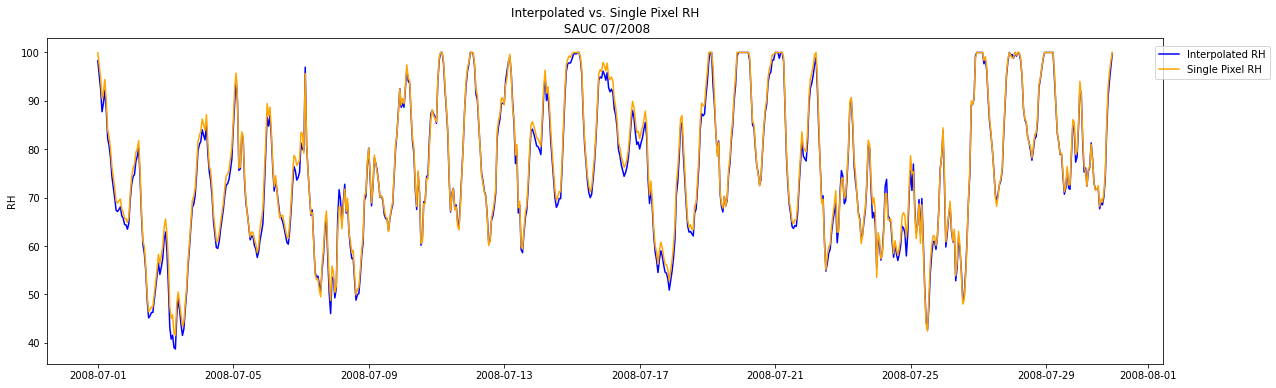

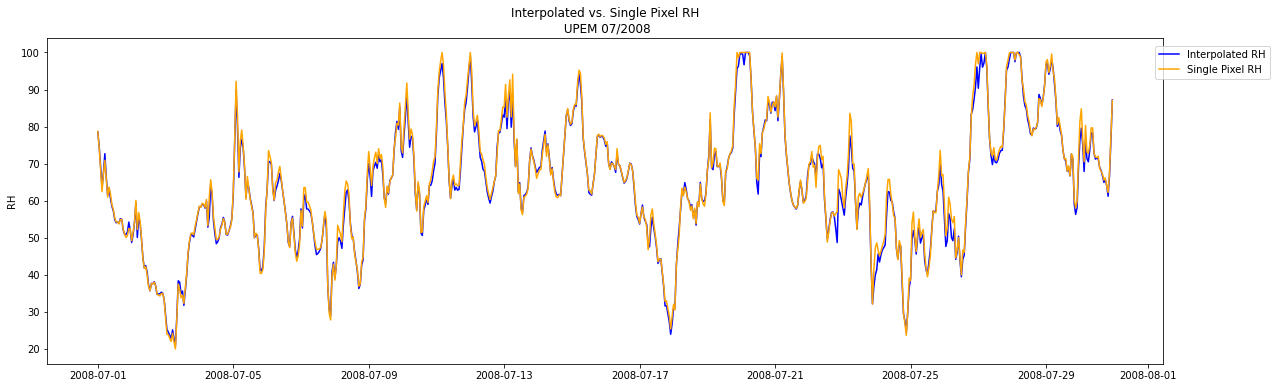

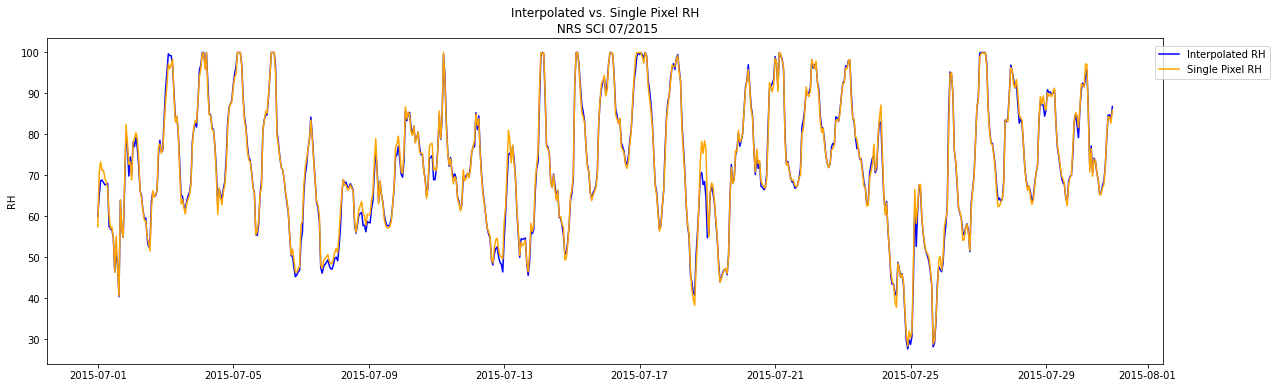

In [6]:
#### July RH ####
daterange = ['2008-07-01','2008-07-30']
nrs_daterange = ['2015-07-01', '2015-07-30']
plot_var(intsauc, spsauc, intvar, spvar, daterange, 'SAUC')
plot_var(intupem, spupem, intvar, spvar, daterange, 'UPEM')
plot_var(intnrs_sci, spnrs_sci, intvar, spvar, nrs_daterange, 'NRS SCI')

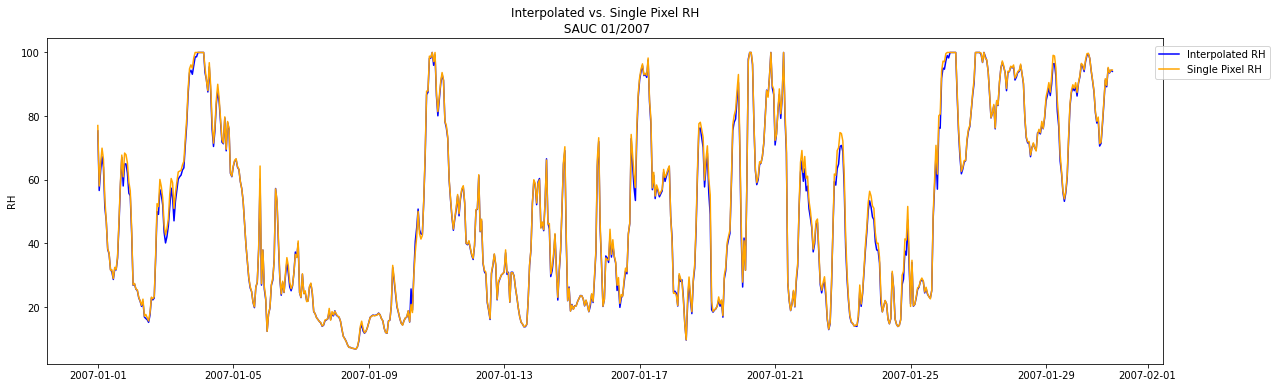

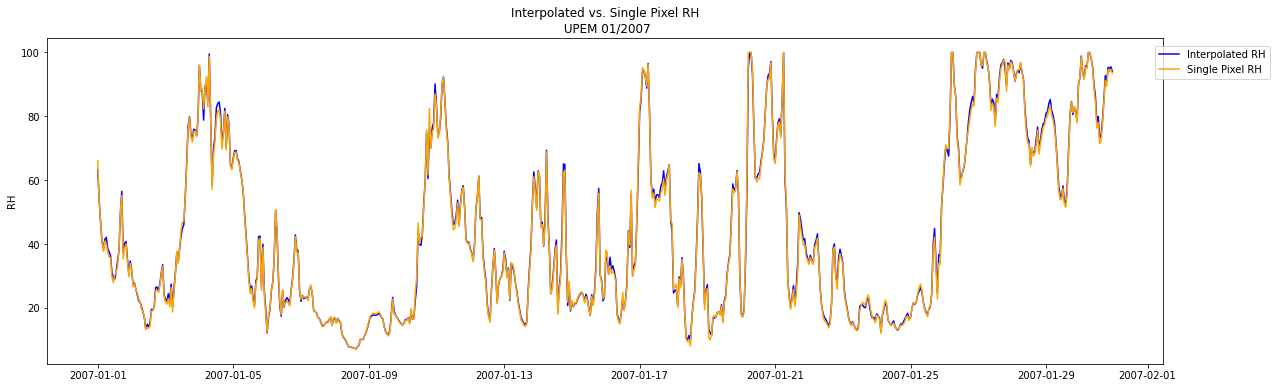

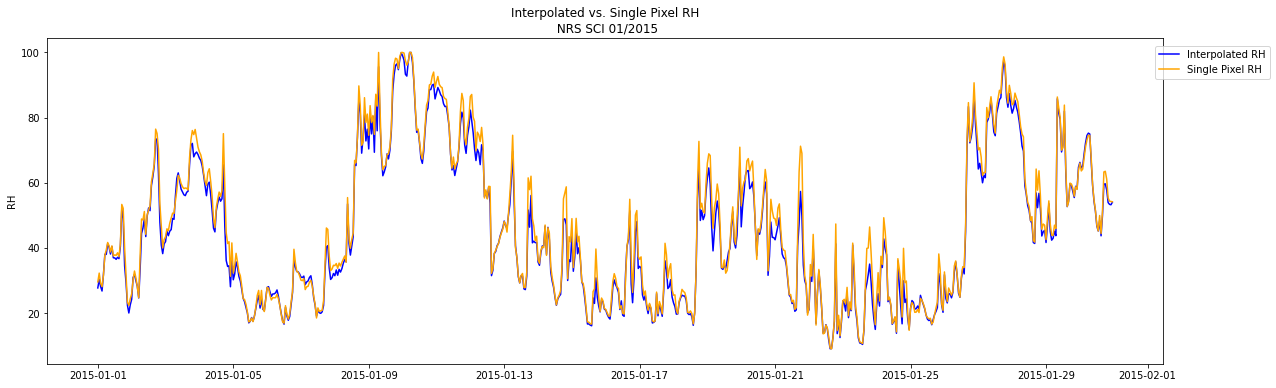

In [7]:
#### January RH ####
daterange = ['2007-01-01','2007-01-30']
nrs_daterange = ['2015-01-01', '2015-01-30']
plot_var(intsauc, spsauc, intvar, spvar, daterange, 'SAUC')
plot_var(intupem, spupem, intvar, spvar, daterange, 'UPEM')
plot_var(intnrs_sci, spnrs_sci, intvar, spvar, nrs_daterange, 'NRS SCI')

## Scatter Plots

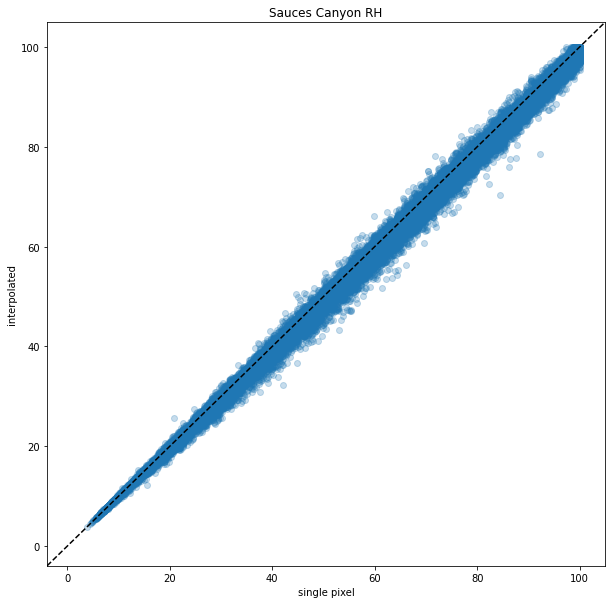

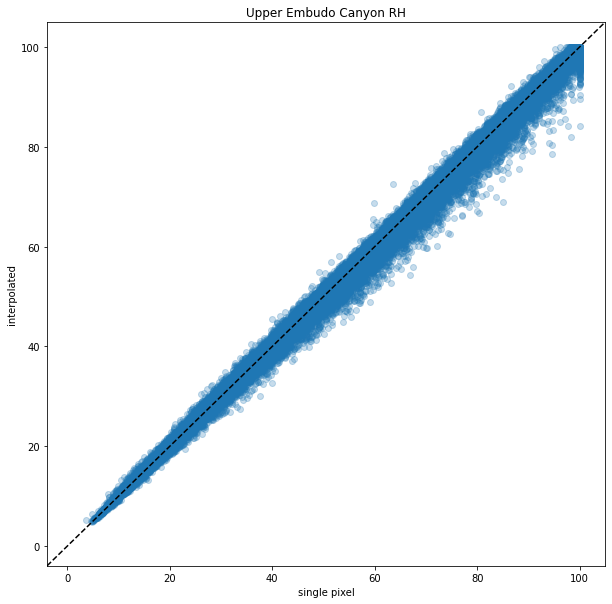

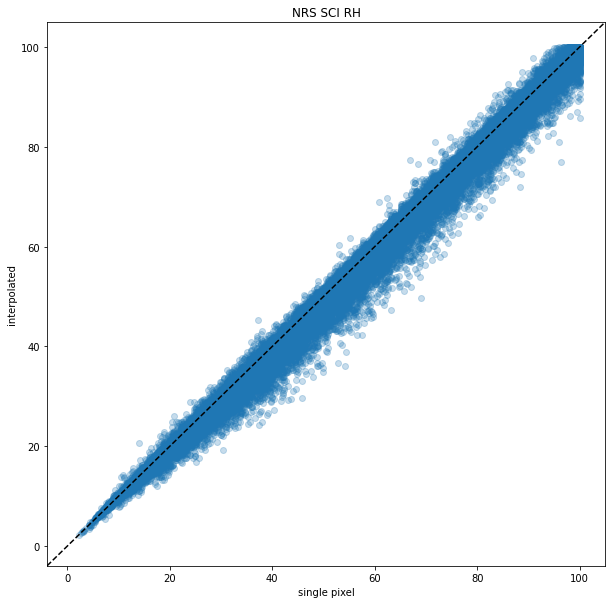

In [8]:
plot_scatter(intsauc, spsauc, intvar, spvar, 'Sauces Canyon')
plot_scatter(intupem, spupem, intvar, spvar, 'Upper Embudo Canyon')
plot_scatter(intnrs_sci, spnrs_sci, intvar, spvar, 'NRS SCI')

## CDF Plots

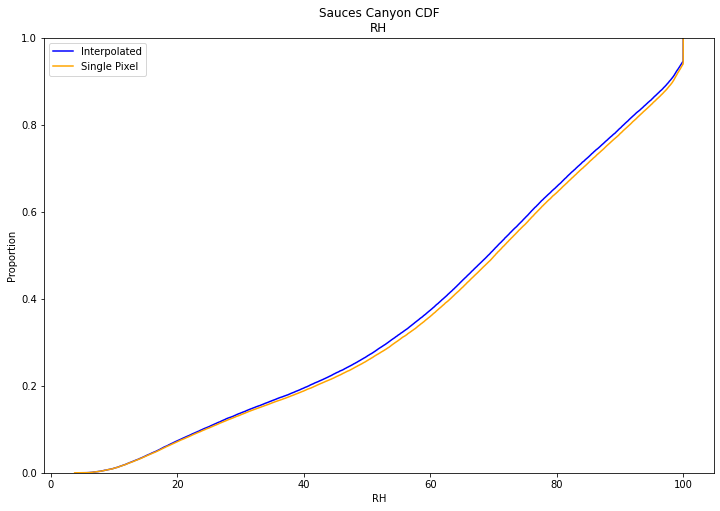

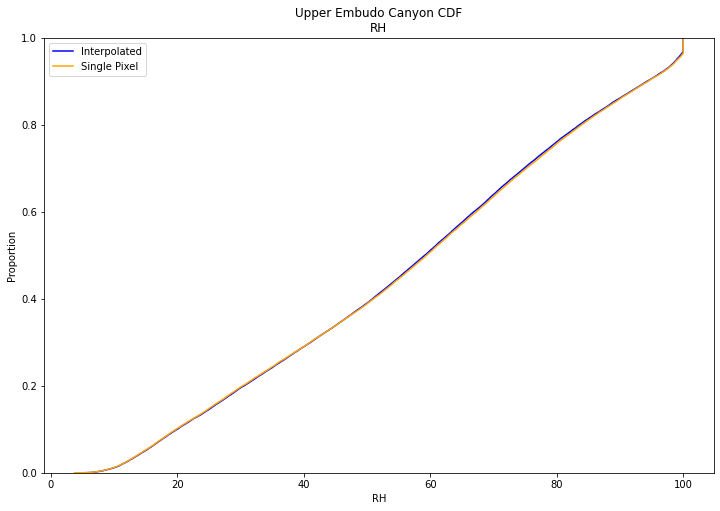

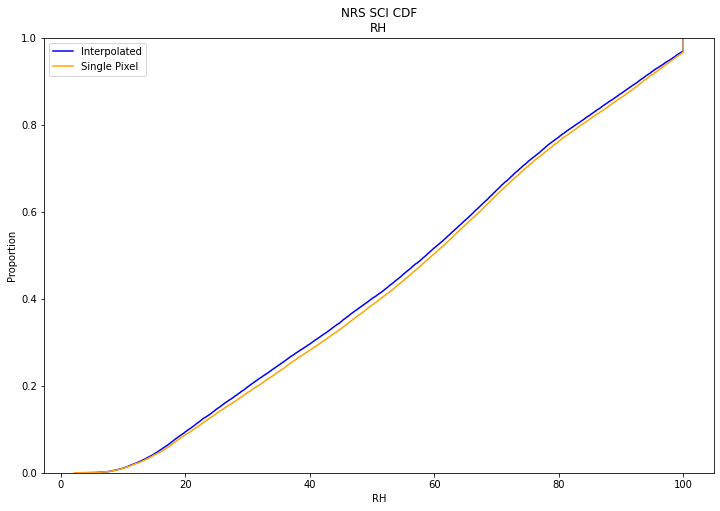

In [9]:
plot_cdf(intsauc, spsauc, intvar, spvar, 'Sauces Canyon')
plot_cdf(intupem, spupem, intvar, spvar, 'Upper Embudo Canyon')
plot_cdf(intnrs_sci, spnrs_sci, intvar, spvar, 'NRS SCI')

## PDF Plots

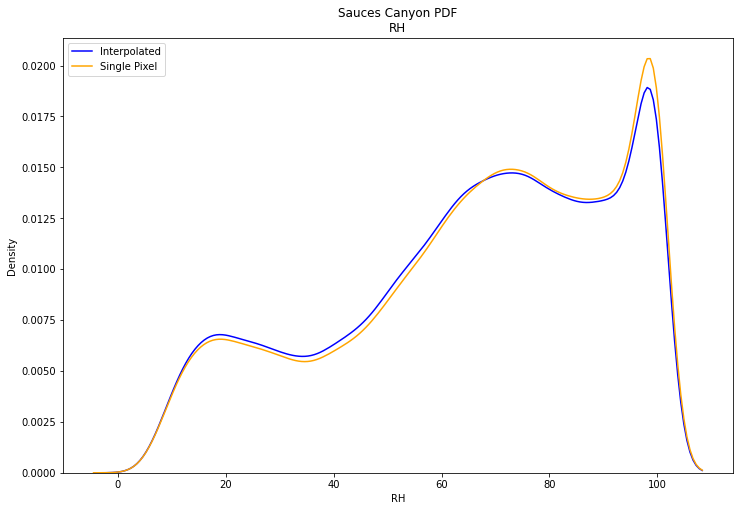

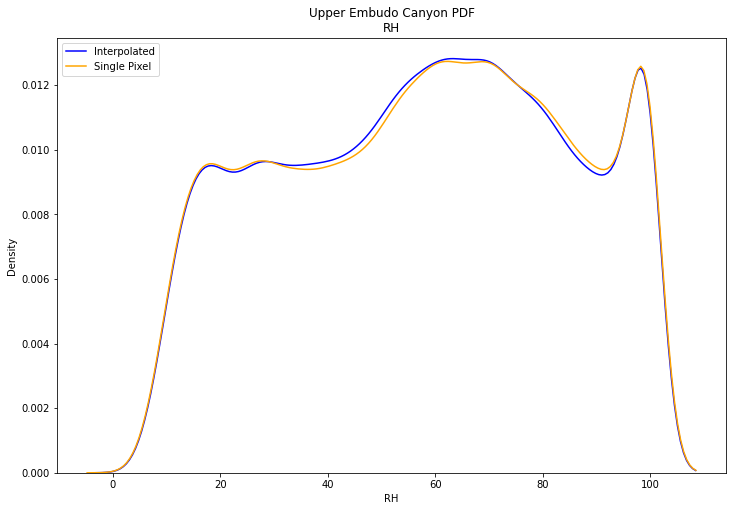

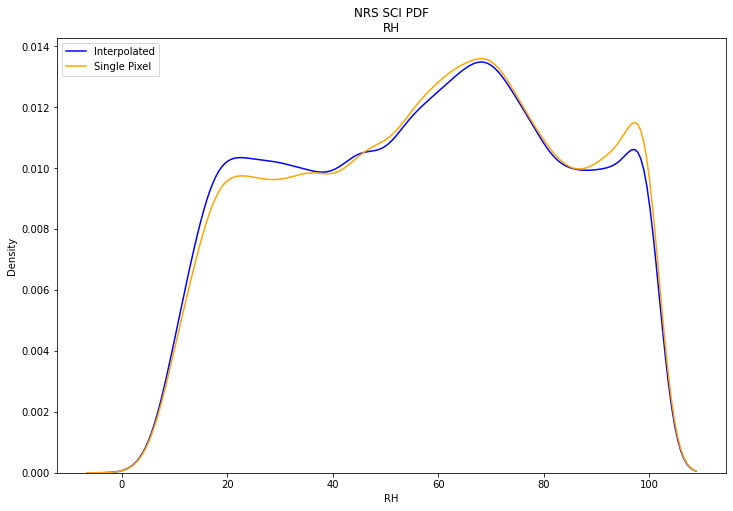

In [10]:
plot_kde(intsauc, spsauc, intvar, spvar, 'Sauces Canyon')
plot_kde(intupem, spupem, intvar, spvar, 'Upper Embudo Canyon')
plot_kde(intnrs_sci, spnrs_sci, intvar, spvar, 'NRS SCI')

## Statistics

In [11]:
print(spvar)
print('Sauces Canyon')
run_stats(intsauc, spsauc, intvar, spvar)

print('Upper Embudo Canyon')
run_stats(intupem, spupem, intvar, spvar)

print('NRS SCI')
run_stats(intnrs_sci, spnrs_sci, intvar, spvar)

RH
Sauces Canyon
Correlation: 1.0
Bias: 0.85
RMSE: 1.37
MAE: 0.98

Upper Embudo Canyon
Correlation: 1.0
Bias: 0.12
RMSE: 1.35
MAE: 0.89

NRS SCI
Correlation: 1.0
Bias: 0.96
RMSE: 2.21
MAE: 1.41



# Air Temperature 

## Time Series Plots

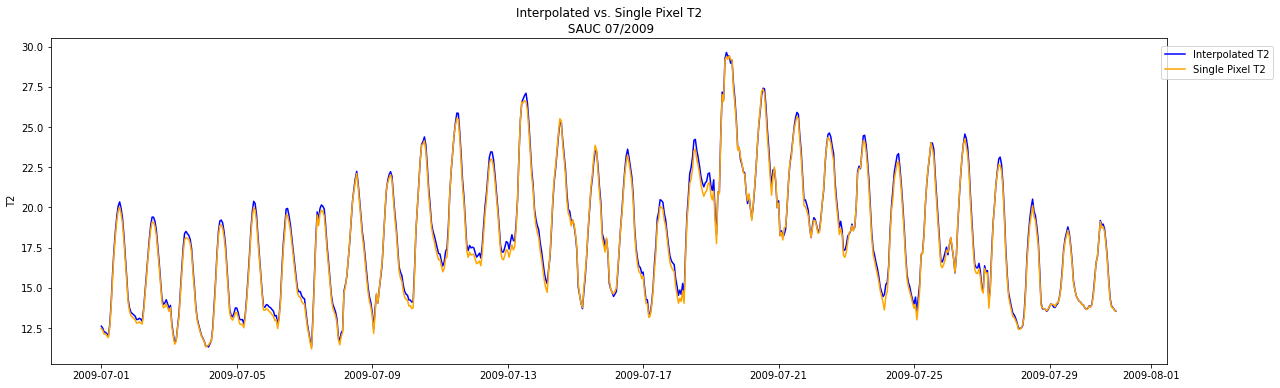

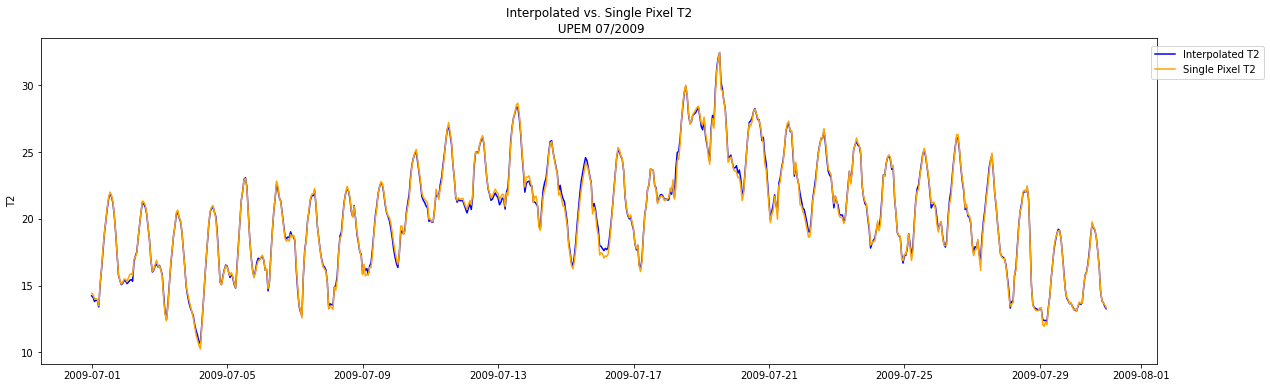

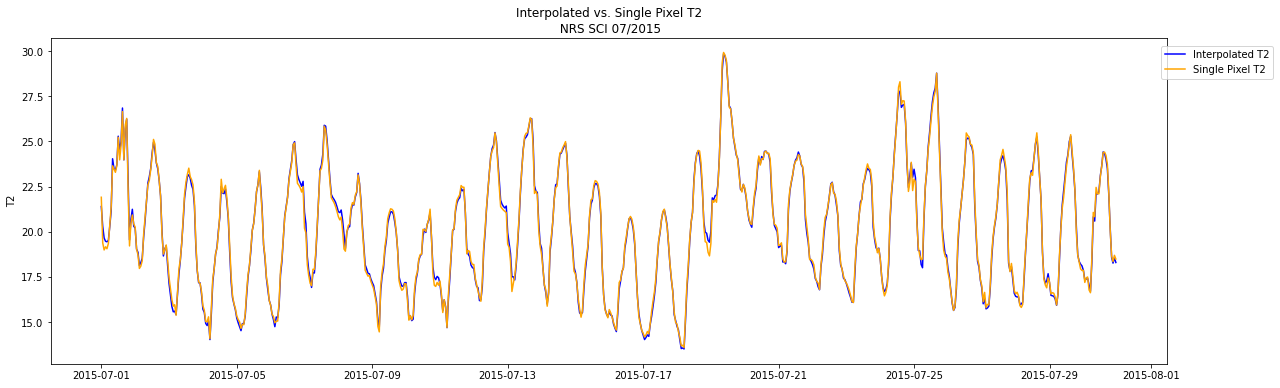

In [12]:
#### July T2 ####
daterange = ['2009-07-01','2009-07-30']
nrs_daterange = ['2015-07-01', '2015-07-30']
intvar = 'T2'
spvar = 'T2'
plot_var(intsauc, spsauc, intvar, spvar, daterange, 'SAUC')
plot_var(intupem, spupem, intvar, spvar, daterange, 'UPEM')
plot_var(intnrs_sci, spnrs_sci, intvar, spvar, nrs_daterange, 'NRS SCI')

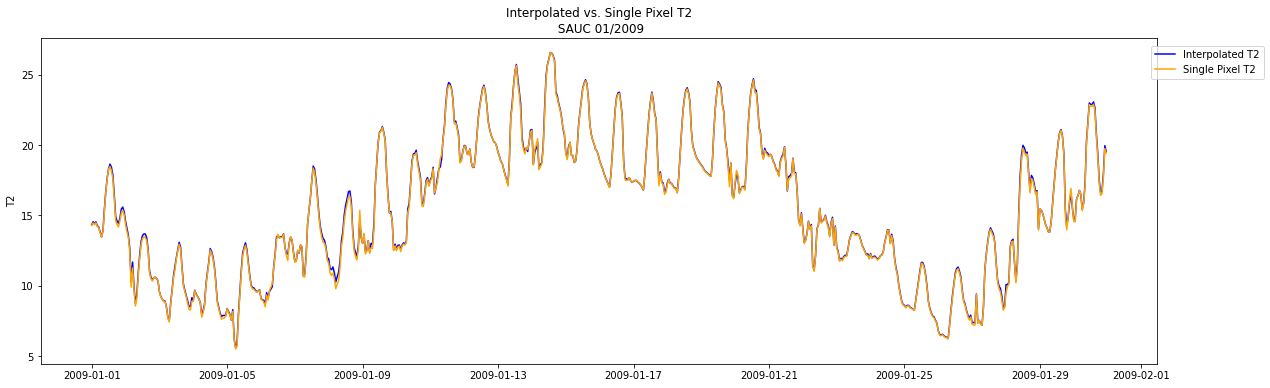

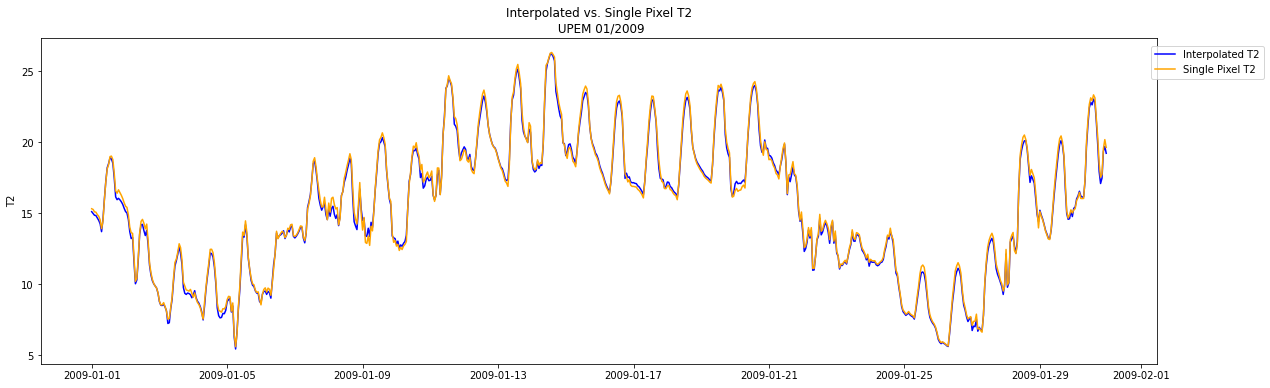

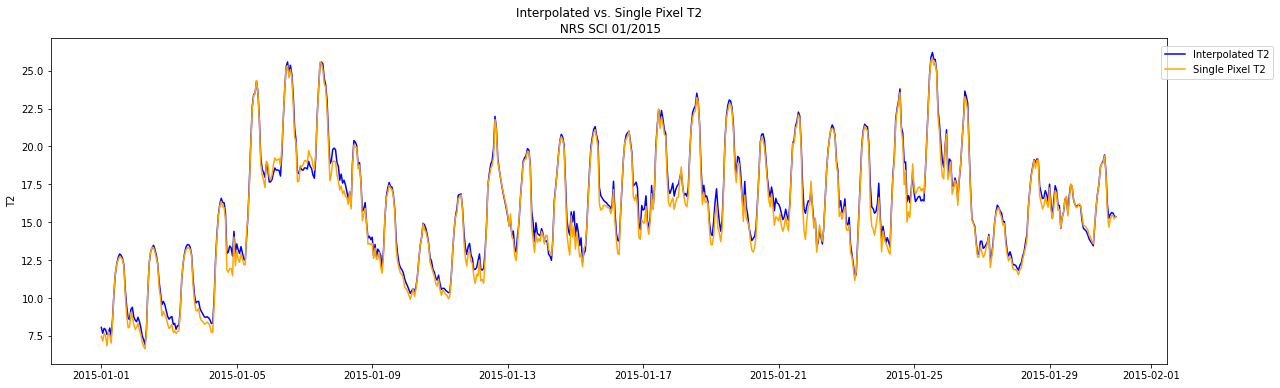

In [13]:
#### January T2 ####
daterange = ['2009-01-01','2009-01-30']
nrs_daterange = ['2015-01-01', '2015-01-30']
intvar = 'T2'
spvar = 'T2'
plot_var(intsauc, spsauc, intvar, spvar, daterange, 'SAUC')
plot_var(intupem, spupem, intvar, spvar, daterange, 'UPEM')
plot_var(intnrs_sci, spnrs_sci, intvar, spvar, nrs_daterange, 'NRS SCI')

## Scatter Plots 

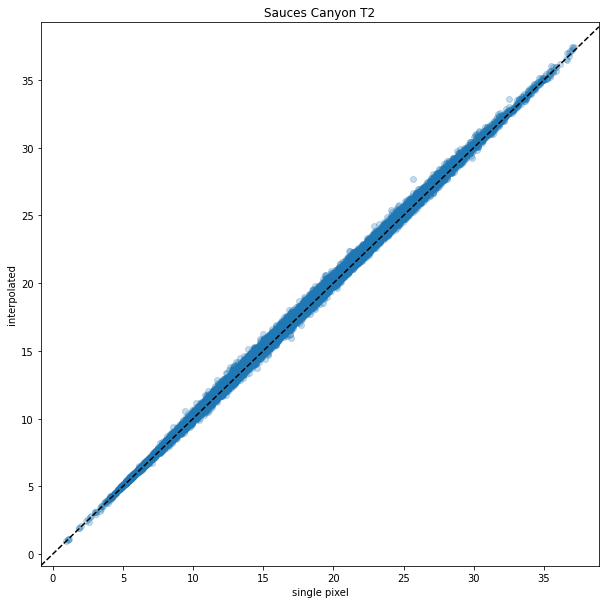

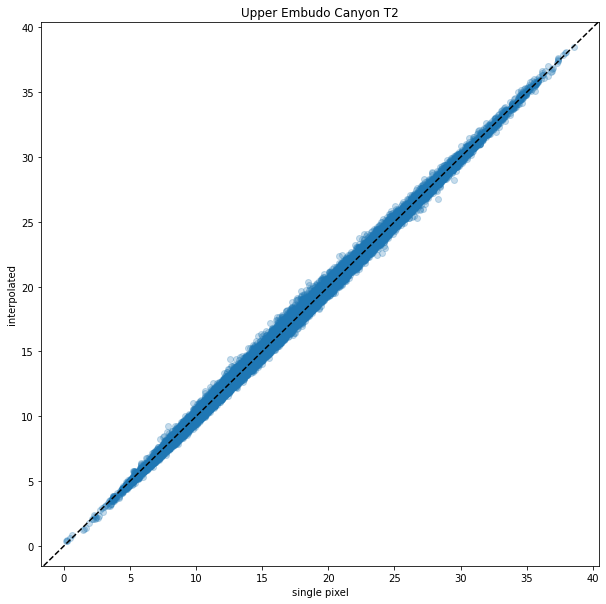

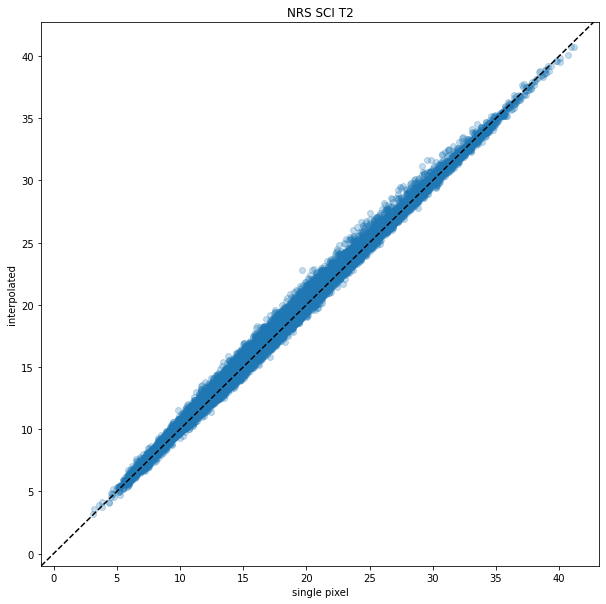

In [14]:
plot_scatter(intsauc, spsauc, intvar, spvar, 'Sauces Canyon')
plot_scatter(intupem, spupem, intvar, spvar, 'Upper Embudo Canyon')
plot_scatter(intnrs_sci, spnrs_sci, intvar, spvar, 'NRS SCI')

## CDF Plot

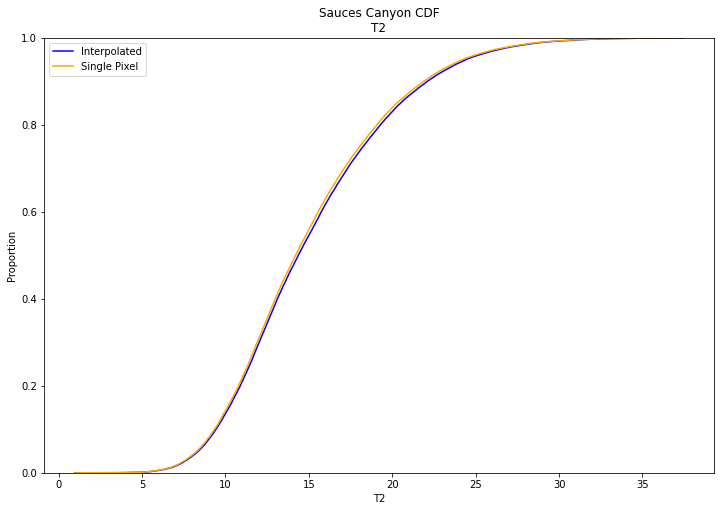

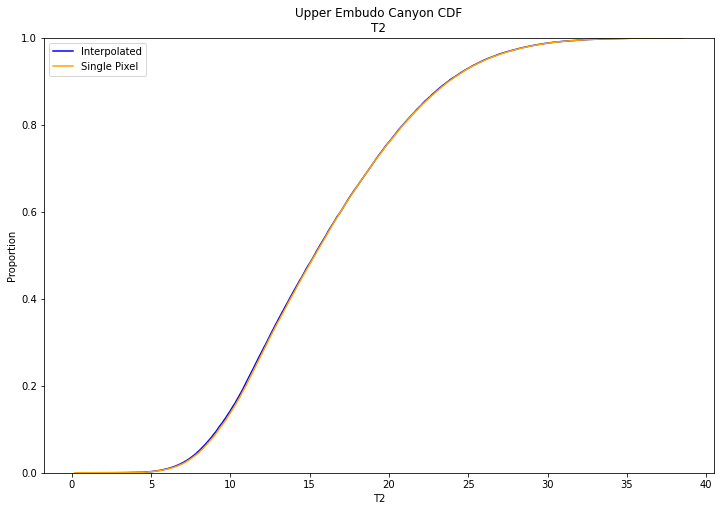

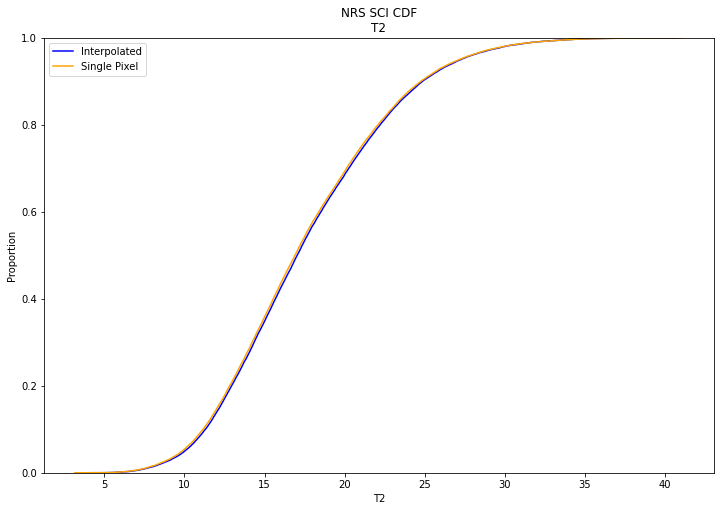

In [15]:
plot_cdf(intsauc, spsauc, intvar, spvar, 'Sauces Canyon')
plot_cdf(intupem, spupem, intvar, spvar, 'Upper Embudo Canyon')
plot_cdf(intnrs_sci, spnrs_sci, intvar, spvar, 'NRS SCI')


## PDF Plots

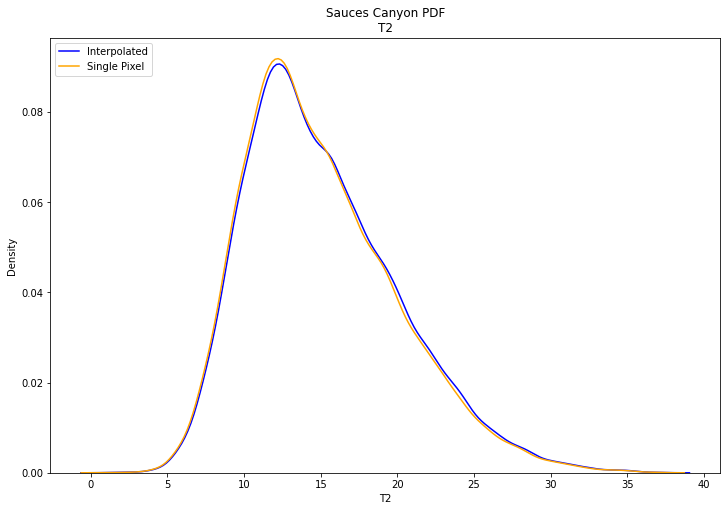

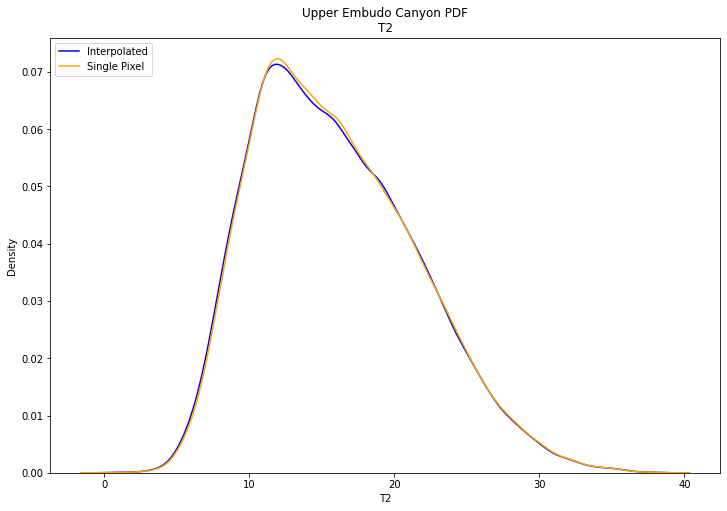

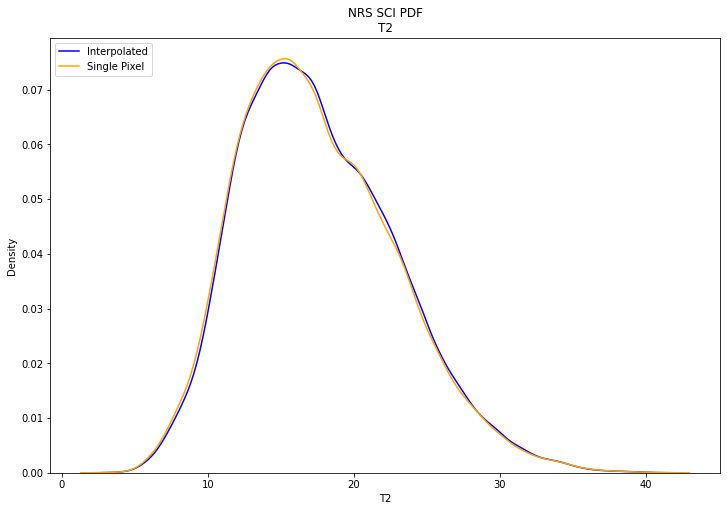

In [16]:
plot_kde(intsauc, spsauc, intvar, spvar, 'Sauces Canyon')
plot_kde(intupem, spupem, intvar, spvar, 'Upper Embudo Canyon')
plot_kde(intnrs_sci, spnrs_sci, intvar, spvar, 'NRS SCI')

## Statistics 

In [17]:
print(spvar)
print(f'Sauces Canyon')
run_stats(intsauc, spsauc, intvar, spvar)

print(f'Upper Embudo Canyon')
run_stats(intupem, spupem, intvar, spvar)

print('NRS SCI')
run_stats(intnrs_sci, spnrs_sci, intvar, spvar)

T2
Sauces Canyon
Correlation: 1.0
Bias: -0.16
RMSE: 0.23
MAE: 0.18

Upper Embudo Canyon
Correlation: 1.0
Bias: 0.05
RMSE: 0.25
MAE: 0.19

NRS SCI
Correlation: 1.0
Bias: -0.13
RMSE: 0.37
MAE: 0.26



# Wind Speed

In [18]:
intvar = 'WND_SPD'
spvar = 'WND_SPD'

## Time Series Plots

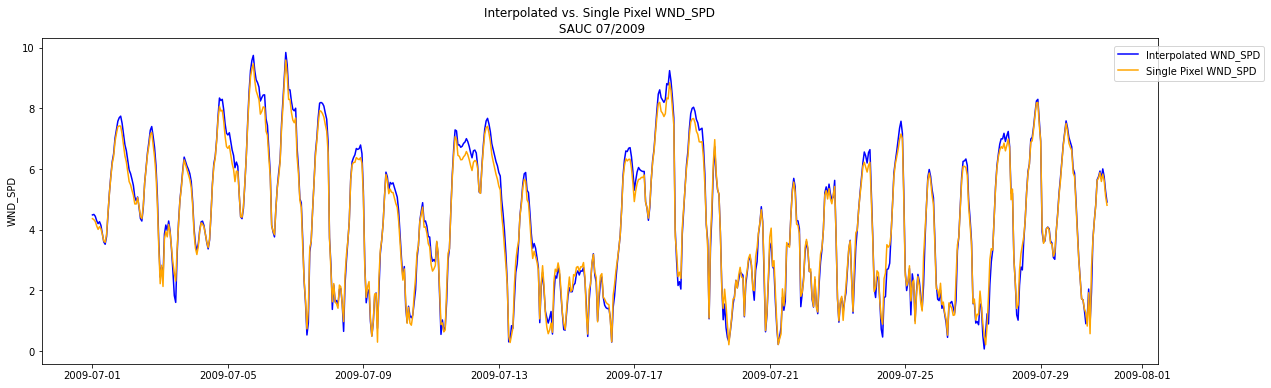

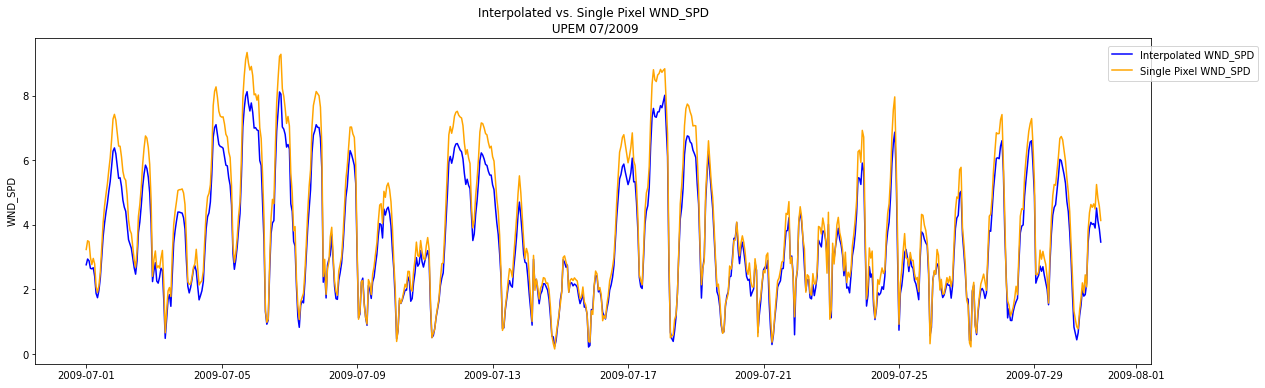

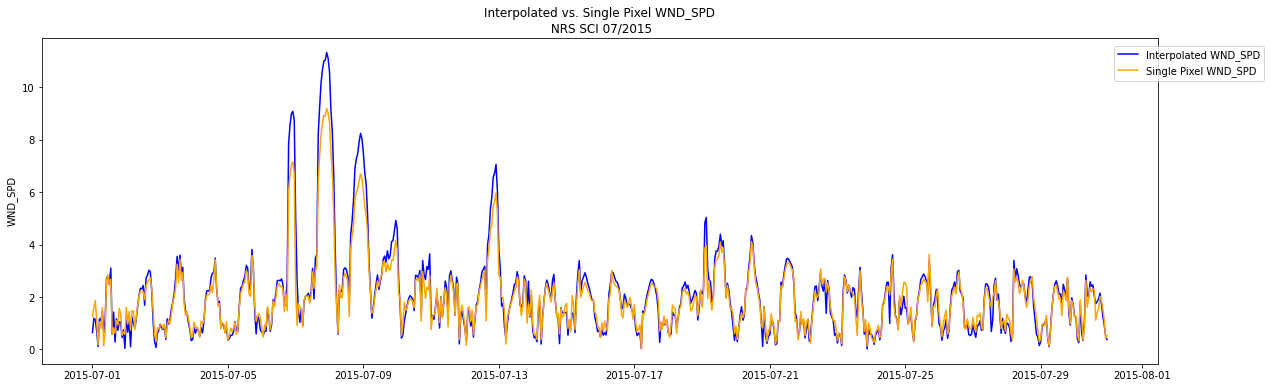

In [19]:
#### July T2 ####
daterange = ['2009-07-01','2009-07-30']
nrs_daterange = ['2015-07-01', '2015-07-30']
plot_var(intsauc, spsauc, intvar, spvar, daterange, 'SAUC')
plot_var(intupem, spupem, intvar, spvar, daterange, 'UPEM')
plot_var(intnrs_sci, spnrs_sci, intvar, spvar, nrs_daterange, 'NRS SCI')

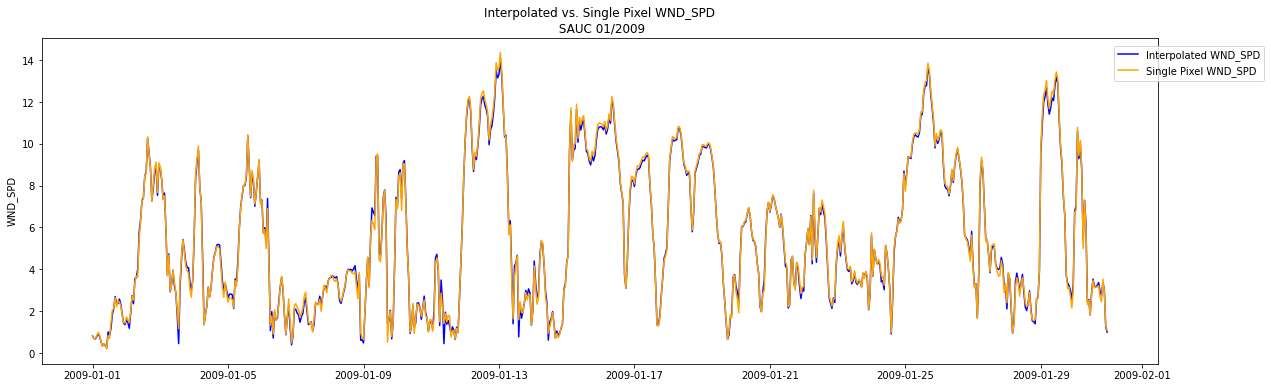

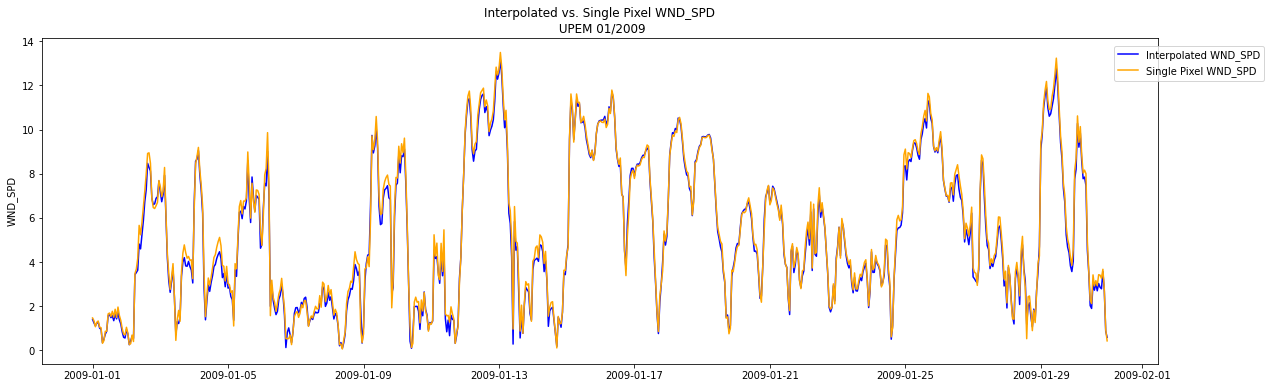

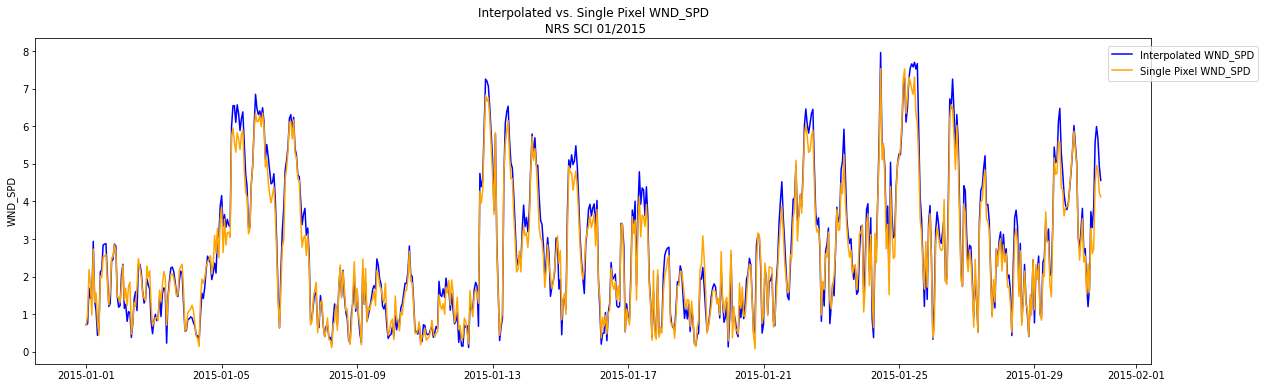

In [20]:
#### January T2 ####
daterange = ['2009-01-01','2009-01-30']
nrs_daterange = ['2015-01-01', '2015-01-30']
plot_var(intsauc, spsauc, intvar, spvar, daterange, 'SAUC')
plot_var(intupem, spupem, intvar, spvar, daterange, 'UPEM')
plot_var(intnrs_sci, spnrs_sci, intvar, spvar, nrs_daterange, 'NRS SCI')

## Scatter Plots 

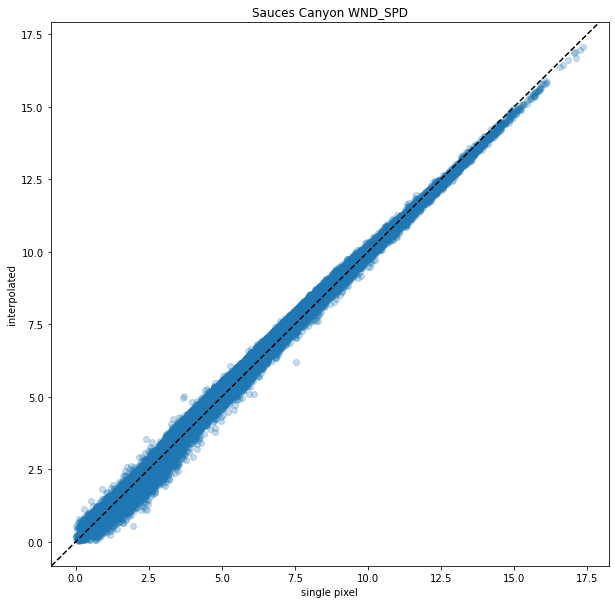

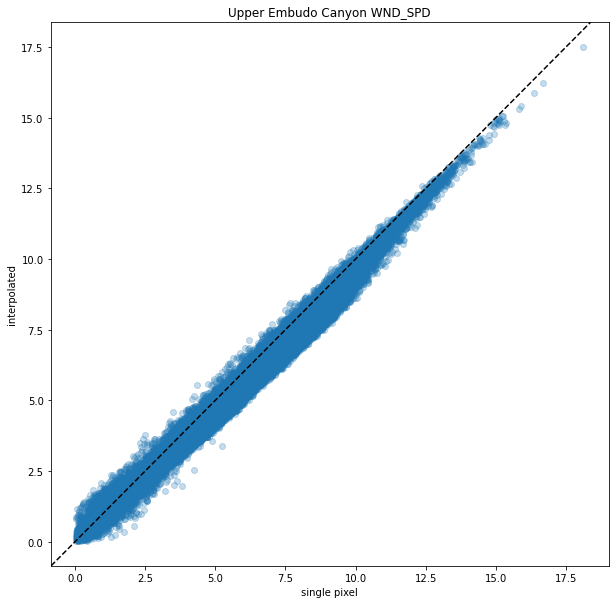

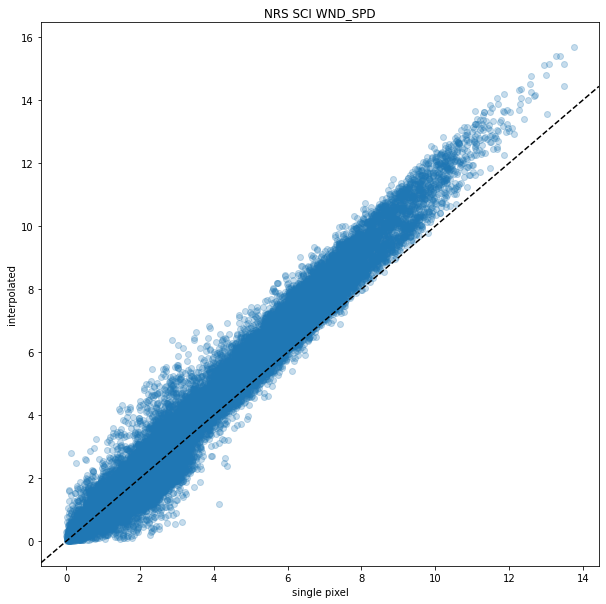

In [21]:
plot_scatter(intsauc, spsauc, intvar, spvar, 'Sauces Canyon')
plot_scatter(intupem, spupem, intvar, spvar, 'Upper Embudo Canyon')
plot_scatter(intnrs_sci, spnrs_sci, intvar, spvar, 'NRS SCI')

## CDF Plot

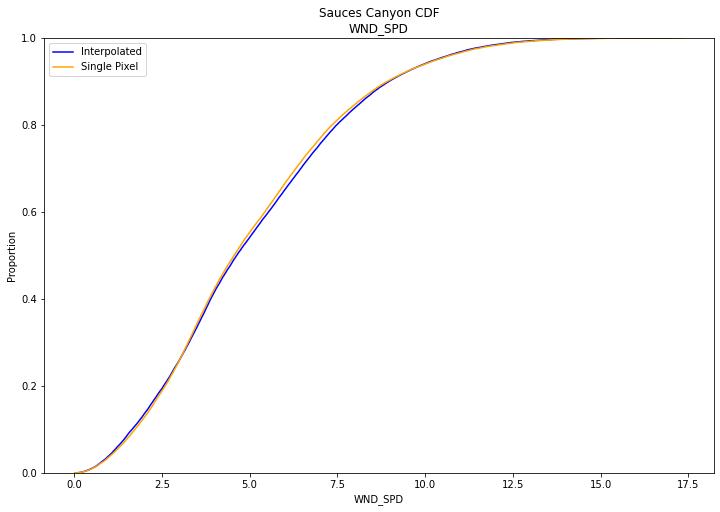

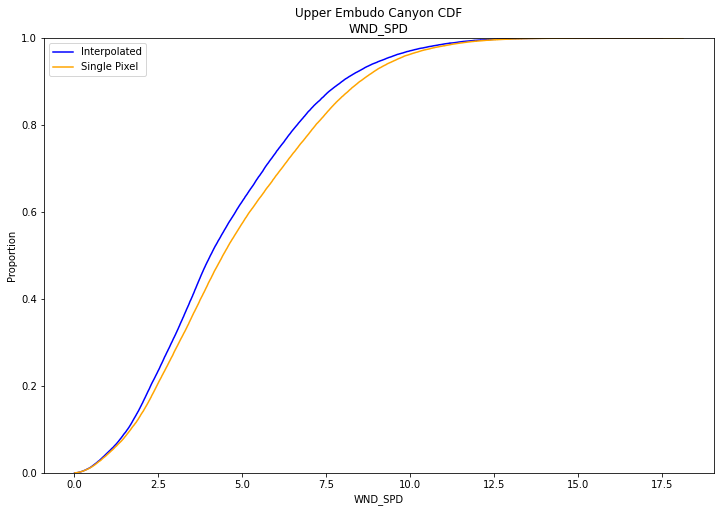

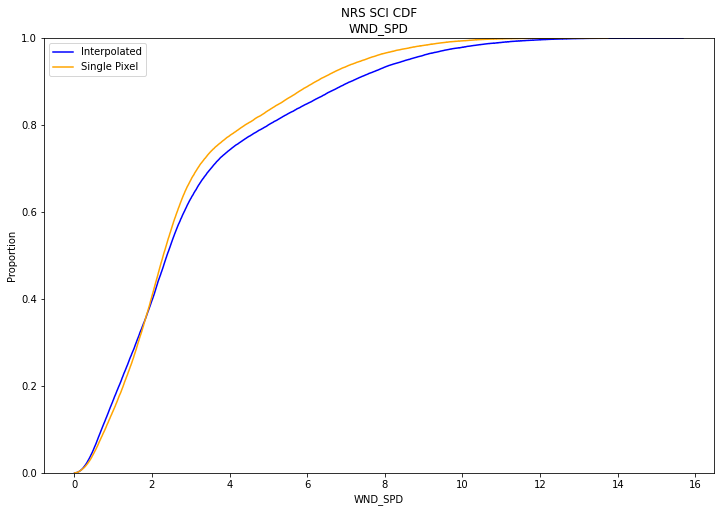

In [22]:
plot_cdf(intsauc, spsauc, intvar, spvar, 'Sauces Canyon')
plot_cdf(intupem, spupem, intvar, spvar, 'Upper Embudo Canyon')
plot_cdf(intnrs_sci, spnrs_sci, intvar, spvar, 'NRS SCI')


## PDF Plots

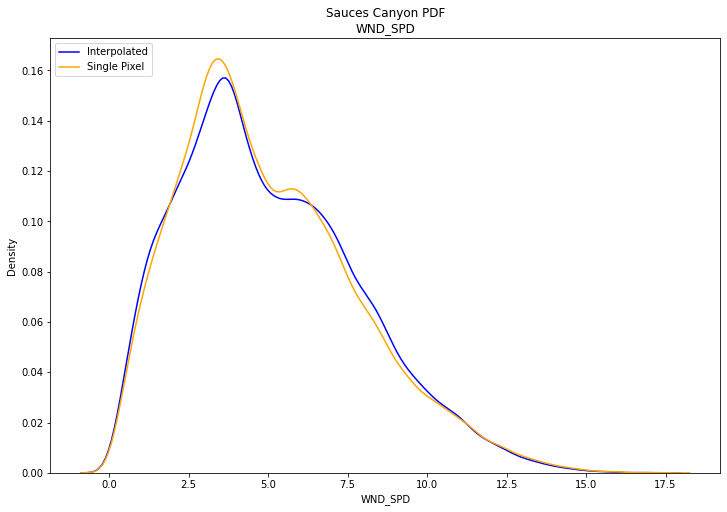

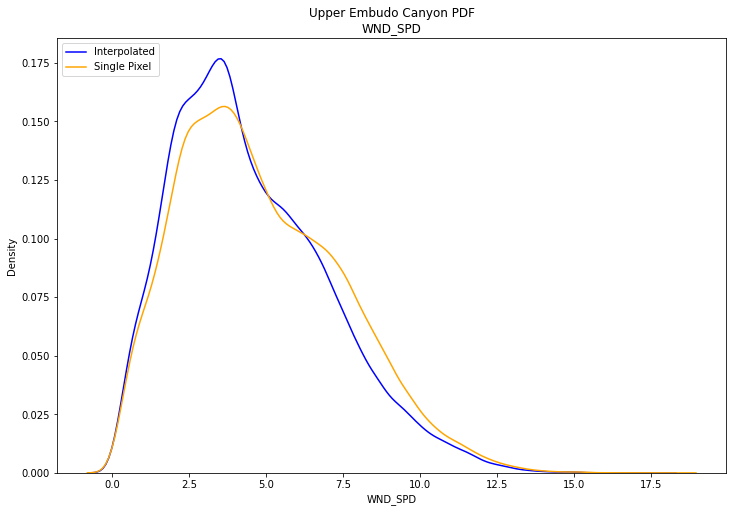

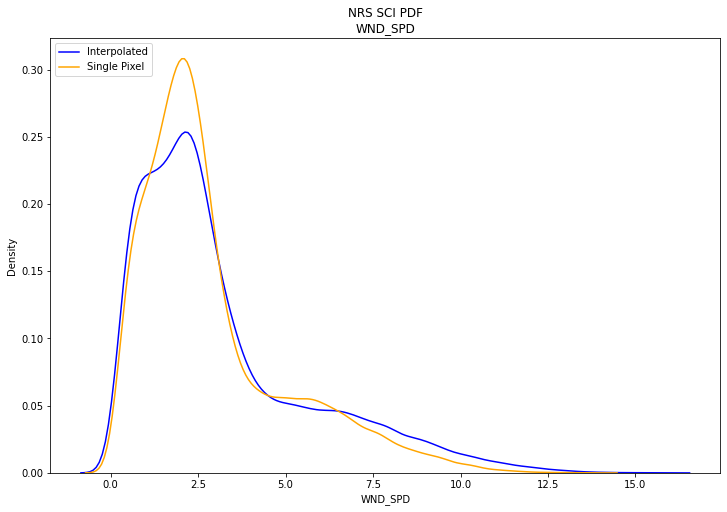

In [23]:
plot_kde(intsauc, spsauc, intvar, spvar, 'Sauces Canyon')
plot_kde(intupem, spupem, intvar, spvar, 'Upper Embudo Canyon')
plot_kde(intnrs_sci, spnrs_sci, intvar, spvar, 'NRS SCI')

## Statistics 

In [24]:
print(spvar)
print(f'Sauces Canyon')
run_stats(intsauc, spsauc, intvar, spvar)

print(f'Upper Embudo Canyon')
run_stats(intupem, spupem, intvar, spvar)

print('NRS SCI')
run_stats(intnrs_sci, spnrs_sci, intvar, spvar)

WND_SPD
Sauces Canyon
Correlation: 1.0
Bias: -0.04
RMSE: 0.2
MAE: 0.15

Upper Embudo Canyon
Correlation: 0.99
Bias: 0.33
RMSE: 0.47
MAE: 0.38

NRS SCI
Correlation: 0.99
Bias: -0.25
RMSE: 0.61
MAE: 0.43



# Wind Direction

In [25]:
intvar = 'WND_DIR'
spvar = 'WND_DIR'

## Time Series Plots

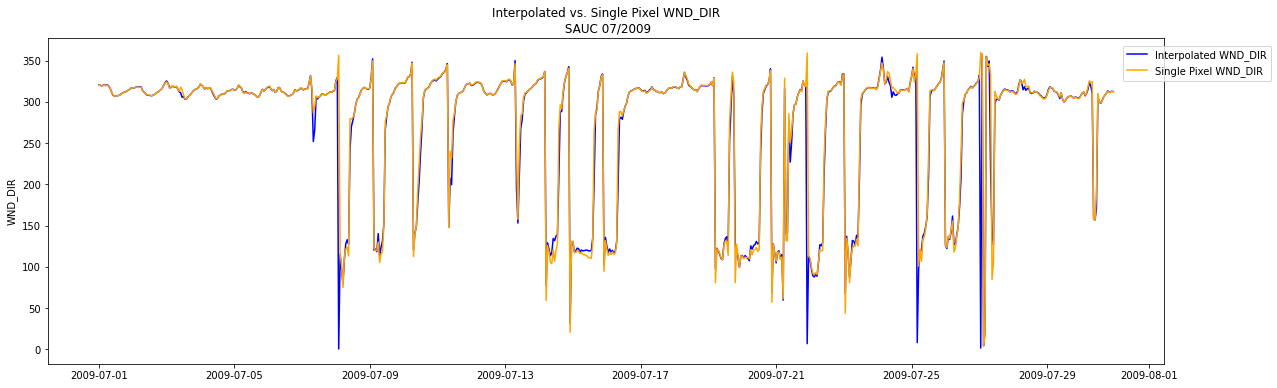

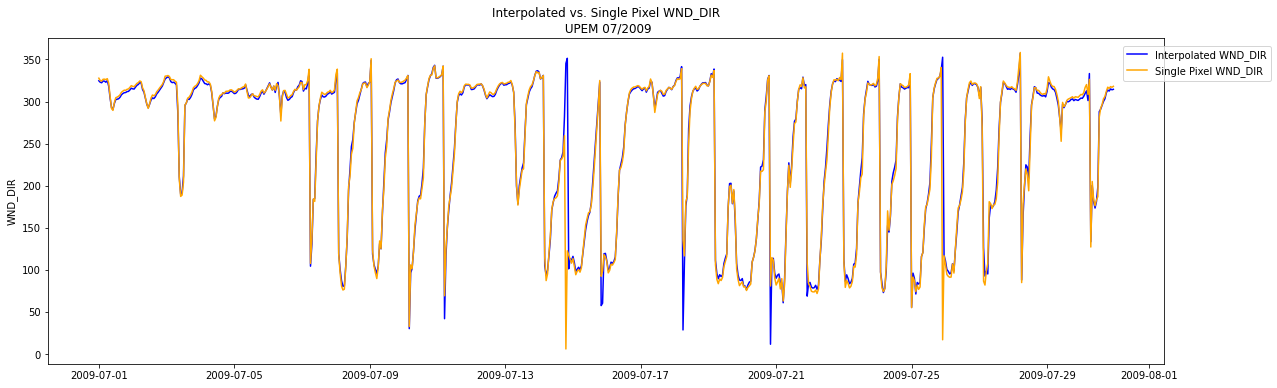

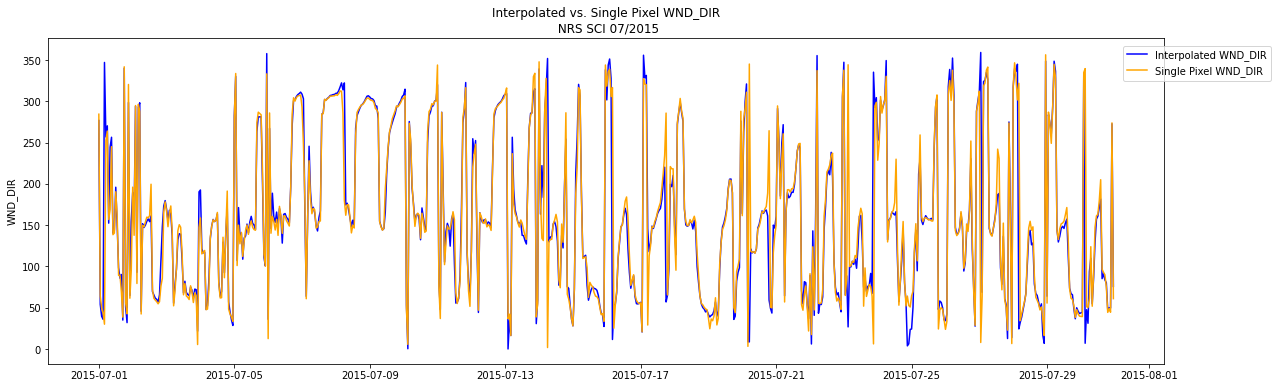

In [26]:
#### July T2 ####
daterange = ['2009-07-01','2009-07-30']
nrs_daterange = ['2015-07-01', '2015-07-30']
plot_var(intsauc, spsauc, intvar, spvar, daterange, 'SAUC')
plot_var(intupem, spupem, intvar, spvar, daterange, 'UPEM')
plot_var(intnrs_sci, spnrs_sci, intvar, spvar, nrs_daterange, 'NRS SCI')

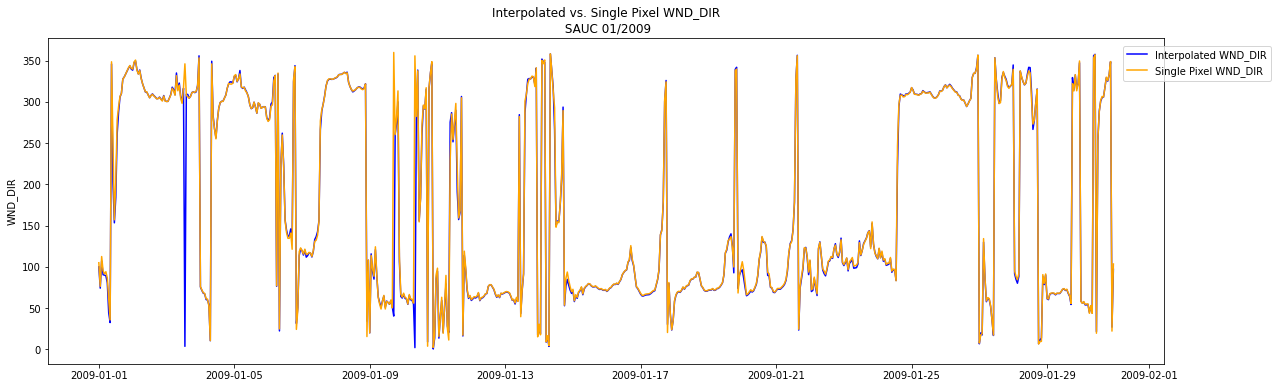

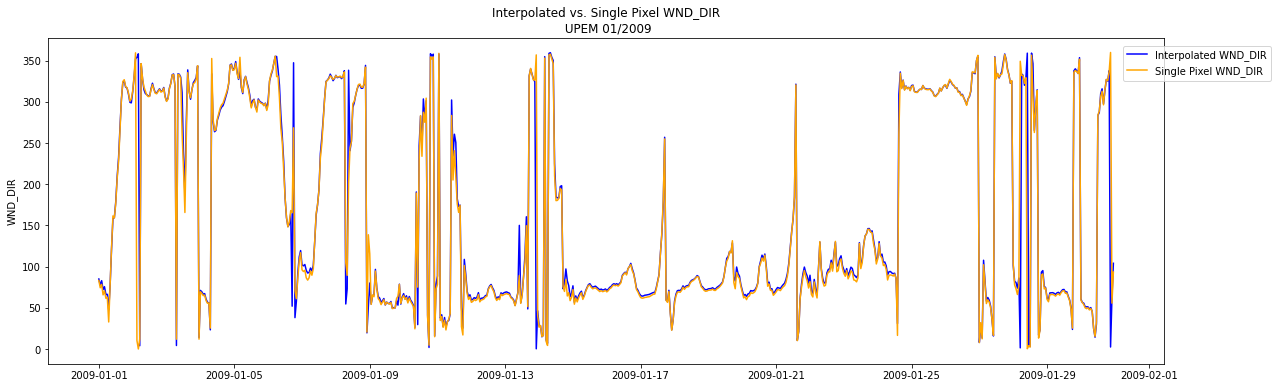

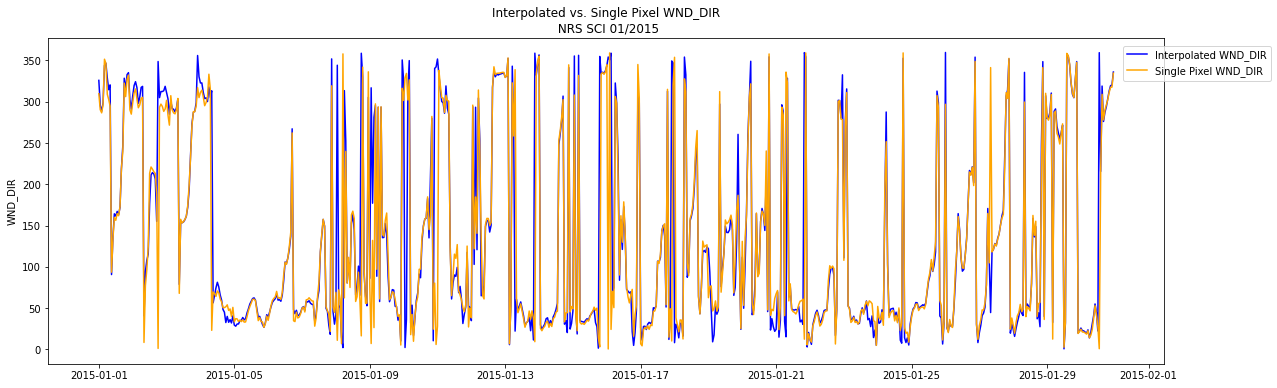

In [27]:
#### January T2 ####
daterange = ['2009-01-01','2009-01-30']
nrs_daterange = ['2015-01-01', '2015-01-30']
plot_var(intsauc, spsauc, intvar, spvar, daterange, 'SAUC')
plot_var(intupem, spupem, intvar, spvar, daterange, 'UPEM')
plot_var(intnrs_sci, spnrs_sci, intvar, spvar, nrs_daterange, 'NRS SCI')

## Scatter Plots 

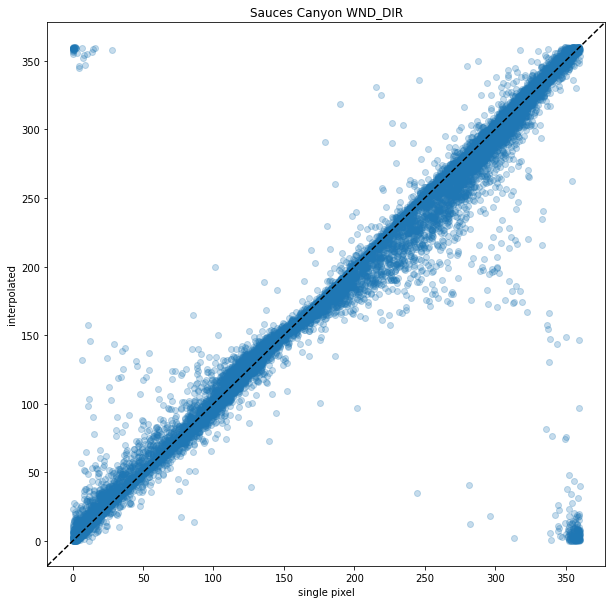

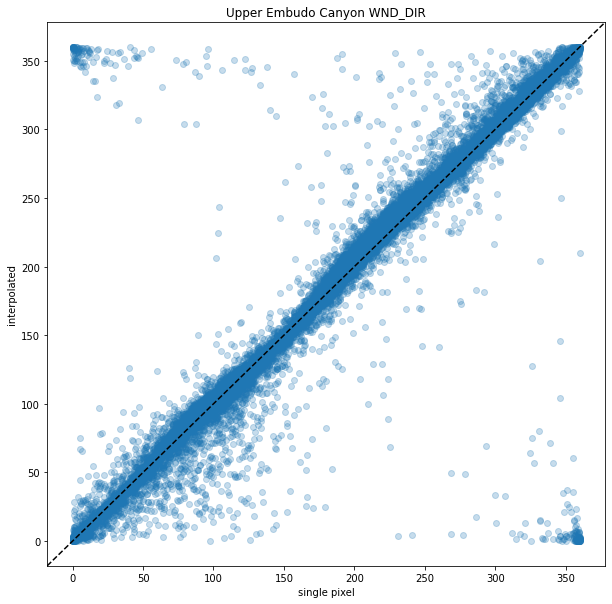

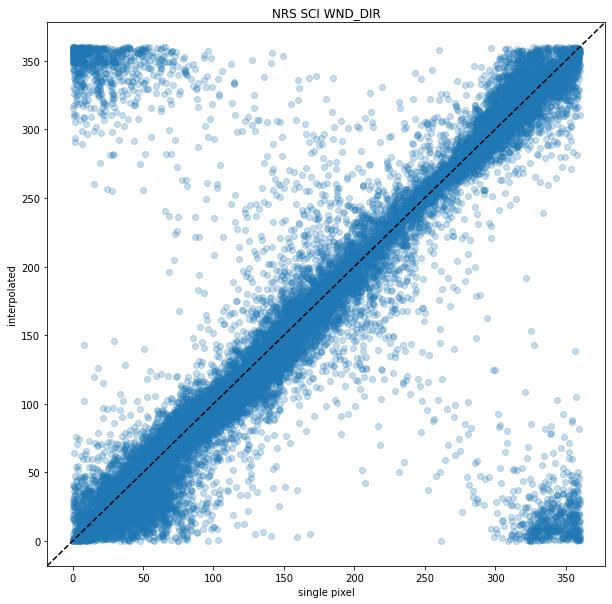

In [28]:
plot_scatter(intsauc, spsauc, intvar, spvar, 'Sauces Canyon')
plot_scatter(intupem, spupem, intvar, spvar, 'Upper Embudo Canyon')
plot_scatter(intnrs_sci, spnrs_sci, intvar, spvar, 'NRS SCI')

## CDF Plot

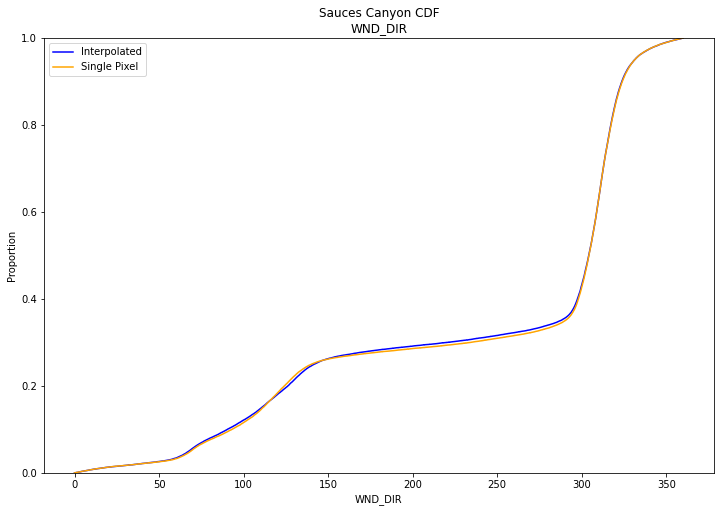

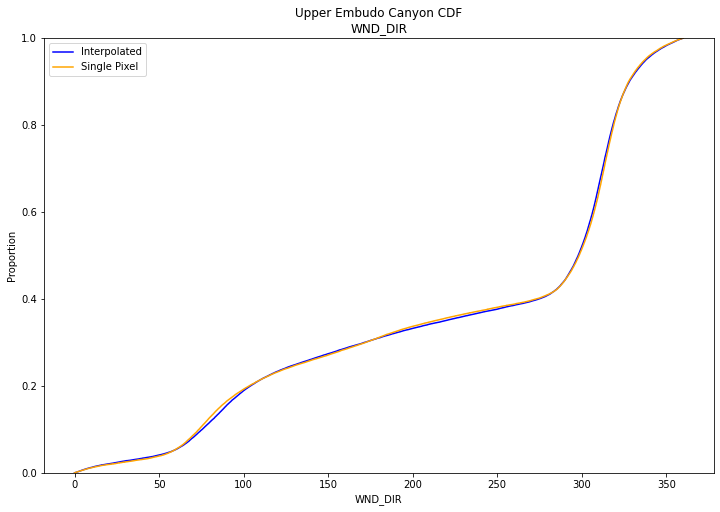

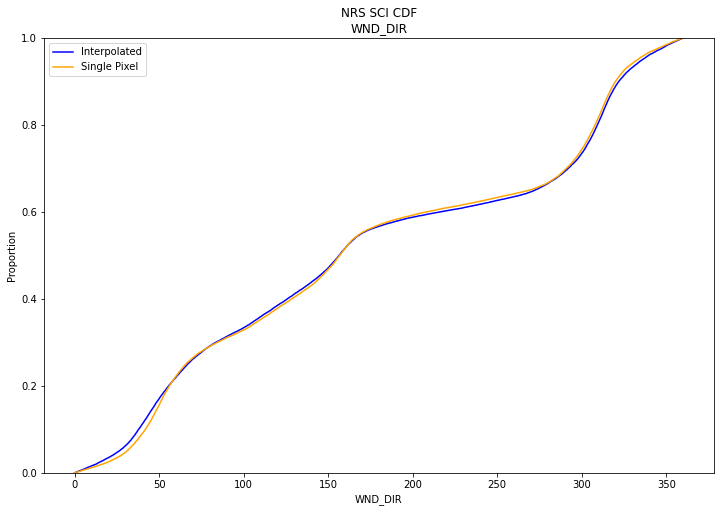

In [29]:
plot_cdf(intsauc, spsauc, intvar, spvar, 'Sauces Canyon')
plot_cdf(intupem, spupem, intvar, spvar, 'Upper Embudo Canyon')
plot_cdf(intnrs_sci, spnrs_sci, intvar, spvar, 'NRS SCI')


## PDF Plots

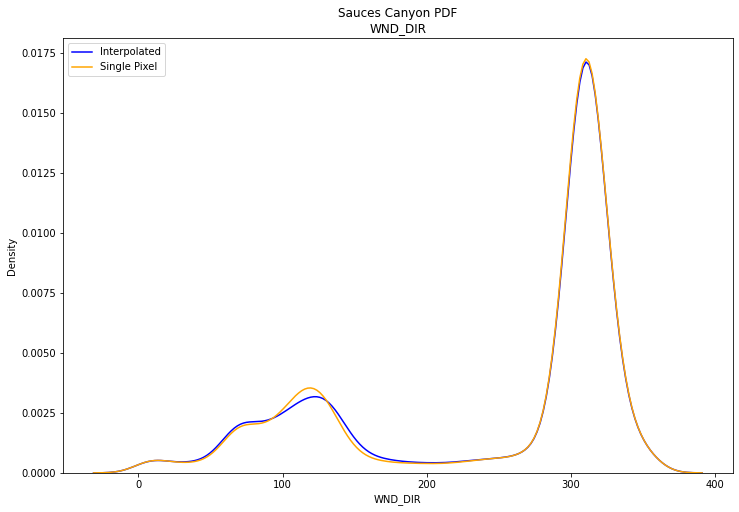

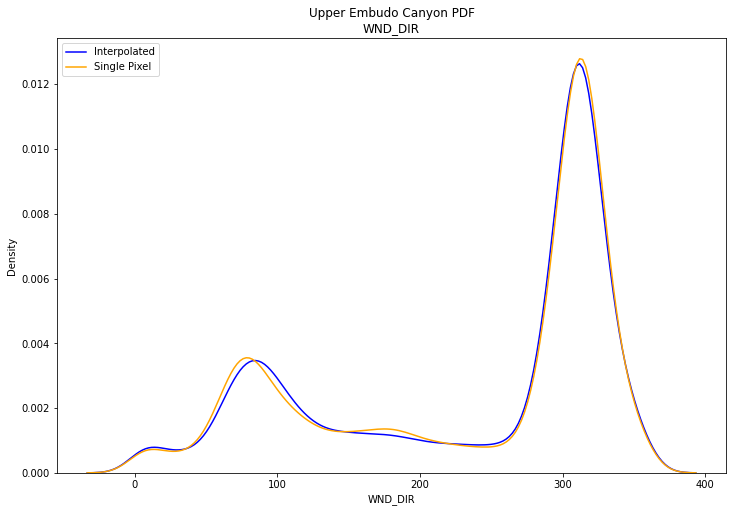

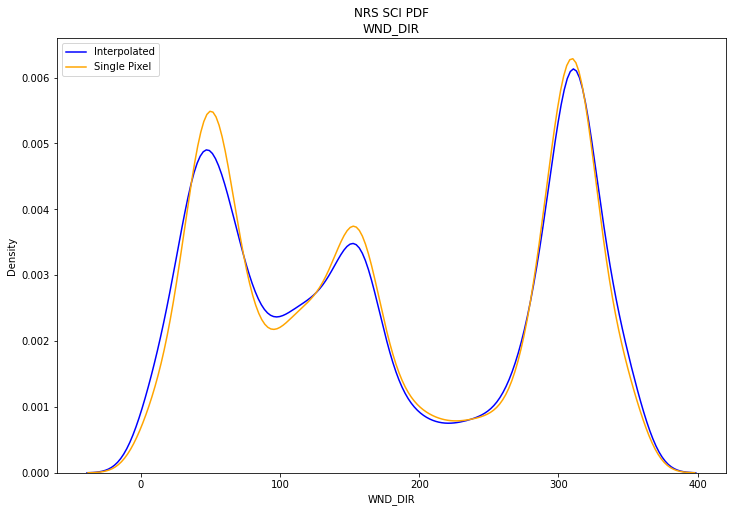

In [30]:
plot_kde(intsauc, spsauc, intvar, spvar, 'Sauces Canyon')
plot_kde(intupem, spupem, intvar, spvar, 'Upper Embudo Canyon')
plot_kde(intnrs_sci, spnrs_sci, intvar, spvar, 'NRS SCI')

## Statistics 

In [31]:
print(spvar)
print(f'Sauces Canyon')
run_stats(intsauc, spsauc, intvar, spvar)

print(f'Upper Embudo Canyon')
run_stats(intupem, spupem, intvar, spvar)

print('NRS SCI')
run_stats(intnrs_sci, spnrs_sci, intvar, spvar)

WND_DIR
Sauces Canyon
Correlation: 0.98
Bias: 0.99
RMSE: 20.26
MAE: 3.12

Upper Embudo Canyon
Correlation: 0.98
Bias: -0.26
RMSE: 21.84
MAE: 4.42

NRS SCI
Correlation: 0.89
Bias: -0.16
RMSE: 52.28
MAE: 15.26



# Fog

In [32]:
intvar = 'DFGDP'
spvar = 'DFGDP'

In [33]:
join_df = intnrs_sci[[intvar]].join(spnrs_sci[[spvar]],  how='inner', lsuffix='_int', rsuffix='_sp')
join_df['condition'] = df.apply(lambda x: label_fog(x['DFGDP_int'], x['DFGDP_sp']), axis=1)
join_df.loc[join_df['DFGDP_sp']>0]

NameError: name 'df' is not defined

In [ ]:
join_df = intsauc[[intvar]].join(spsauc[[spvar]],  how='inner', lsuffix='_int', rsuffix='_sp')
join_df['condition'] = df.apply(lambda x: label_fog(x['DFGDP_int'], x['DFGDP_sp']), axis=1)
join_df.loc[join_df['DFGDP_sp']>0]

## Scatter Plots 

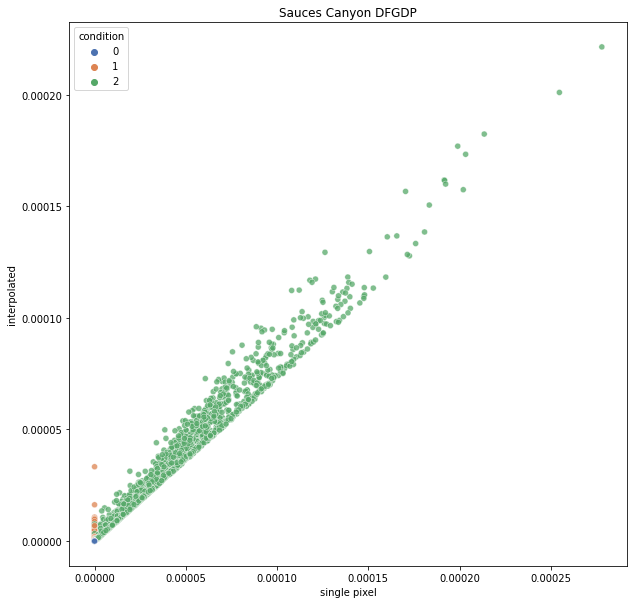

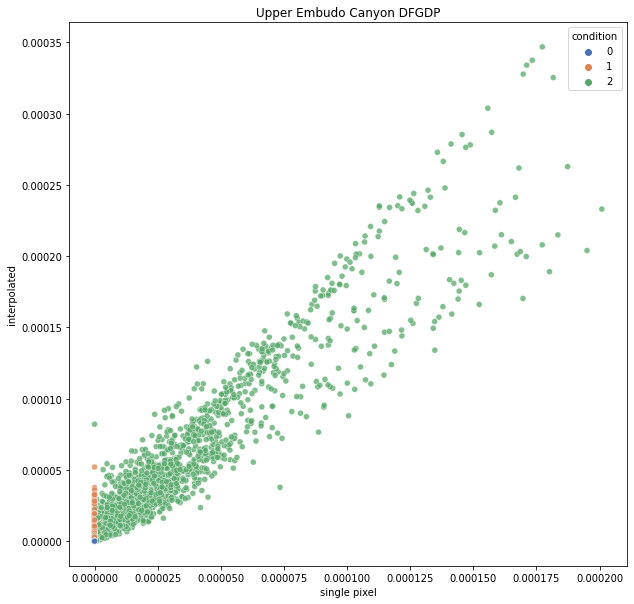

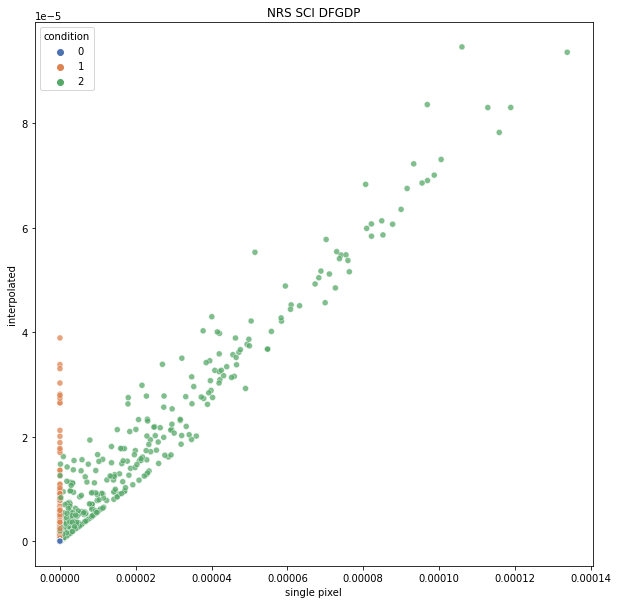

In [35]:
def plot_scatter(intdf, spdf, intvar, spvar, site):
    join_df = intdf[[intvar]].join(spdf[[spvar]],  how='inner', lsuffix='_int', rsuffix='_sp')
    
    title_var = intvar
    intvar = intvar + '_int'
    spvar = spvar + '_sp'
    
    join_df['condition'] = join_df.apply(lambda x: label_fog(x['DFGDP_int'], x['DFGDP_sp']), axis=1)
    
    fig, ax = plt.subplots(figsize=(10,10))
    sns.scatterplot(data=join_df,
                x='DFGDP_sp',
                y='DFGDP_int',
                hue='condition',
                palette='deep',
                alpha=.75)
    
    ax.set(xlabel='single pixel',
           ylabel='interpolated',
           title=f'{site} {title_var}')
    
    
    #plt.legend()
    plt.show()
    

plot_scatter(intsauc, spsauc, intvar, spvar, 'Sauces Canyon')
plot_scatter(intupem, spupem, intvar, spvar, 'Upper Embudo Canyon')
plot_scatter(intnrs_sci, spnrs_sci, intvar, spvar, 'NRS SCI')
